## **Paquetes**

In [1]:
%%capture
# Paquete de Python que facilita la manipulación de datos terrestres
!pip install earthpy

# Librería Basemap
#!pip install "basemap == 1.3.0b1" "basemap-data == 1.3.0b1" "basemap-data-hires == 1.3.0b1"

# Raster managing package installing
!pip install rioxarray

# Basemap tiles package
!pip3 install contextily

# Auxiliary functions for geopandas
!pip install rtree

# Artist for matplotlib to display a scale bar
!pip install matplotlib-scalebar

In [2]:
# Se importan funciones auxiliares desde GitHub para la cuantificación de datos
# faltantes
!git clone https://github.com/jsblandon/weather_data_uy_preprocessing.git
import sys
sys.path.append('/content/weather_data_uy_preprocessing')

Cloning into 'weather_data_uy_preprocessing'...
remote: Enumerating objects: 10, done.
remote: Counting objects: 100% (10/10), done.
remote: Compressing objects: 100% (10/10), done.
remote: Total 10 (delta 2), reused 3 (delta 0), pack-reused 0 (from 0)
Receiving objects: 100% (10/10), 4.80 KiB | 4.80 MiB/s, done.
Resolving deltas: 100% (2/2), done.


In [3]:
import contextily as cx            # basemap tiles
import glob                        # files managing
import geopandas as gpd            # shapefile managing
import math                        # math operations
import matplotlib.colors as colors # customize colors
import matplotlib.pyplot as plt    # plots
import numpy as np                 # array managing
import os                          # directory managing
import pandas as pd                # structured data managing
import rioxarray as rxr            # raster managing
import seaborn as sns              # plots
import matplotlib.image as mpimg   # to add compass to maps
from geopandas import GeoDataFrame # to create GeoPandas DataFrames
from glob import glob              # files managing
from matplotlib import rc          # LaTeX-based commands
from matplotlib_scalebar.scalebar import ScaleBar
from matplotlib.colors import to_rgba # color conversion
from matplotlib.colors import LinearSegmentedColormap
from mpl_toolkits.axes_grid1 import make_axes_locatable # colorbar positioning
from pandas import DataFrame       # pandas dataframe structure
from shapely.geometry import mapping, Point, Polygon # for clipping rasters using shapes and geometries managing
from tqdm import tqdm              # Progress tracking
from warnings import simplefilter  # get rid off warnings
from weather_data_preprocessing import null_report
from zipfile import ZipFile        # .zip files managing

In [4]:
# Plot settings
%matplotlib inline
%config InlineBackend.figure_formats = ['svg']

sns.set_style('whitegrid')
simplefilter("ignore")
plt.rcParams["font.family"] = 'sans-serif'

In [5]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## **Funciones**

In [6]:
def save_fig(fig_id, tight_layout=True, fig_extension="png", resolution=300):
    f""" Funcion para guardar figuras eficientemente

        Recibe
        ------
        fig_id : string
            Identificador de la figura

        Devuelve
        --------
        Figura almacenada en el directorio de trabajo

        Fuente: Géron, A. (2022). Hands-on machine learning with Scikit-Learn,
        Keras, and TensorFlow. " O'Reilly Media, Inc.".

    """
    path =  f"{fig_id}.{fig_extension}"
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format=fig_extension, dpi=resolution,bbox_inches="tight",transparent=True)

## **Principal**

# Procesamiento avistamientos de aves endémicas en peligro (VU)

In [7]:
# Ruta del archivo CSV: María Victoria y Paula
file_path = '/content/drive/MyDrive/Proyecto aplicado /Procesamiento objetivo 1/2003_2023_aves_endemicas_co_vu.csv'

# Ruta del archivo CSV: Juan
# file_path = '/content/drive/MyDrive/research/codes/Proyecto aplicado /2003_2023_aves_endemicas_co_en.csv'

# Leer el archivo CSV con la opción low_memory=False
df_vu = pd.read_csv(file_path, low_memory=False)

# Mostrar las primeras filas del dataframe
df_vu.head()

,Unnamed: 0,checklist_id,last_edited_date,country,country_code,state,state_code,county,county_code,iba_code,...,behavior_code,age_sex,observation_count,species_observed,status_co,effort_hours,effort_speed_kmph,hours_of_day,year,day_of_year
0,1,S60360053,2023-11-25 21:52:57.837266,Colombia,CO,Antioquia,CO-ANT,NaN,NaN,NaN,...,NaN,NaN,0.0,False,Vulnerable,0.533333,0.75,7.983333,2019,278
1,2,S60360053,2023-11-25 21:52:57.837266,Colombia,CO,Antioquia,CO-ANT,NaN,NaN,NaN,...,NaN,NaN,0.0,False,Vulnerable,0.533333,0.75,7.983333,2019,278
2,3,S60360053,2023-11-25 21:52:57.837266,Colombia,CO,Antioquia,CO-ANT,NaN,NaN,NaN,...,NaN,NaN,0.0,False,Vulnerable,0.533333,0.75,7.983333,2019,278
3,4,S60360053,2023-11-25 21:52:57.837266,Colombia,CO,Antioquia,CO-ANT,NaN,NaN,NaN,...,NaN,NaN,0.0,False,Vulnerable,0.533333,0.75,7.983333,2019,278
4,5,S60360053,2023-11-25 21:52:57.837266,Colombia,CO,Antioquia,CO-ANT,NaN,NaN,NaN,...,NaN,NaN,0.0,False,Vulnerable,0.533333,0.75,7.983333,2019,278


In [8]:
# Mostrar el total de filas y columnas
print("\nTotal de filas y columnas en el DataFrame:")
print(df_vu.shape)


Total de filas y columnas en el DataFrame:
(6065655, 45)


In [9]:
# Verificacion de tipos de datos
df_vu.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6065655 entries, 0 to 6065654
Data columns (total 45 columns):
 #   Column                     Dtype  
---  ------                     -----  
 0   Unnamed: 0                 int64  
 1   checklist_id               object 
 2   last_edited_date           object 
 3   country                    object 
 4   country_code               object 
 5   state                      object 
 6   state_code                 object 
 7   county                     float64
 8   county_code                float64
 9   iba_code                   float64
 10  bcr_code                   float64
 11  usfws_code                 float64
 12  atlas_block                float64
 13  locality                   object 
 14  locality_id                object 
 15  locality_type              object 
 16  latitude                   float64
 17  longitude                  float64
 18  observation_date           object 
 19  time_observations_started  object 
 20  ob

In [10]:
# Recuento de datos nulos
null_report(df_vu)

,variables,null_values
0,Unnamed: 0,0.000000
1,checklist_id,0.000000
2,last_edited_date,0.000000
3,country,0.000000
4,country_code,0.000000
5,state,0.000000
6,state_code,0.000000
7,county,100.000000
8,county_code,100.000000
9,iba_code,100.000000


In [11]:
# Descartar columna Unnamed que resultó de cargar los datos desde R
df_vu.drop(columns=["Unnamed: 0"], inplace=True)

In [12]:
# Descartaremos variables que tengan valores muy altos de datos faltantes
dis_vars = ['county','county_code','iba_code','bcr_code','usfws_code','atlas_block',
            'effort_area_ha','breeding_code','breeding_category','behavior_code',
            'age_sex']
df_vu.drop(columns=dis_vars, inplace=True)

In [13]:
# Descartaremos filas de datos faltantes, por ejemplo de la cantidad de
# ejemplares en un avistamiento (observation_count) y cantidad de horas
# del día empleadas para hacer el avistamiento (hours_of_day)
df_vu = df_vu[df_vu['observation_count'].isnull() == False]
df_vu = df_vu[df_vu['hours_of_day'].isnull() == False]

In [14]:
# Convertimos a los tipos de datos que identificaron las funciones del paquete
# auk() cuando se preprocesaron los datos
char_attributes = ["checklist_id","country","country_code","state","state_code",
                   "locality","locality_id","locality_type","observer_id",
                   "sampling_event_identifier","protocol_type","protocol_code",
                   "project_code","group_identifier","trip_comments","scientific_name",
                   "time_observations_started"]
date_attributes = ["last_edited_date","observation_date",]
float_attributes= ["latitude","longitude","effort_distance_km",
                   "effort_hours","effort_speed_kmph","hours_of_day","year",
                   "day_of_year"]
int_attributes  = ["duration_minutes","number_observers","observation_count"]
bool_attributes = ["all_species_reported","species_observed"]

In [15]:
# Conversion a tipos de datos float (flotantes)
df_vu[float_attributes] = df_vu[float_attributes].astype(float)
# Conversion a tipos de datos integer (enteros)
df_vu[int_attributes] = df_vu[int_attributes].astype(int)
# Conversion a tipos de datos boolean (booleanos)
df_vu[bool_attributes] = df_vu[bool_attributes].astype(bool)

In [16]:
# Data type verification (again)
df_vu.info()

<class 'pandas.core.frame.DataFrame'>
Index: 6065028 entries, 0 to 6065654
Data columns (total 33 columns):
 #   Column                     Dtype  
---  ------                     -----  
 0   checklist_id               object 
 1   last_edited_date           object 
 2   country                    object 
 3   country_code               object 
 4   state                      object 
 5   state_code                 object 
 6   locality                   object 
 7   locality_id                object 
 8   locality_type              object 
 9   latitude                   float64
 10  longitude                  float64
 11  observation_date           object 
 12  time_observations_started  object 
 13  observer_id                object 
 14  sampling_event_identifier  object 
 15  protocol_type              object 
 16  protocol_code              object 
 17  project_code               object 
 18  duration_minutes           int64  
 19  effort_distance_km         float64
 20  number_

Saving figure Abundance_departamentos
Saving figure Abundance_departamentos


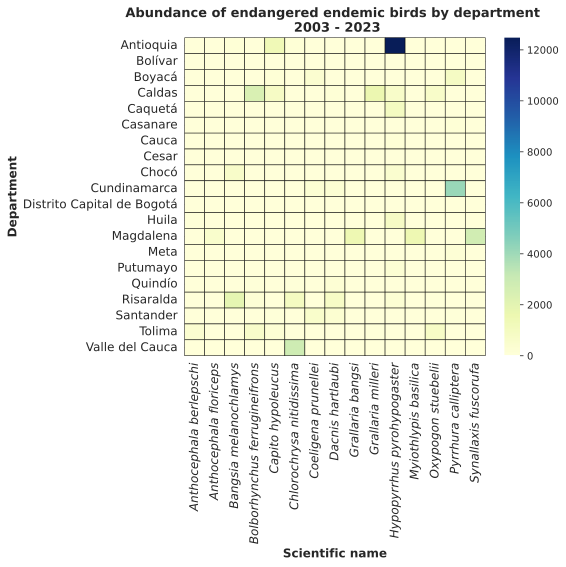

In [17]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Filtrar los datos para incluir solo los avistamientos donde observation_count es mayor a 0
filtered_data = df_vu[df_vu['observation_count'] > 0]

# Crear una tabla de contingencia para combinar la presencia de cada "scientific_name" por cada "state"
presence_matrix_1 = pd.crosstab(filtered_data['state'], filtered_data['scientific_name'], values=filtered_data['observation_count'], aggfunc='sum', dropna=False).fillna(0)

# Configurar el tamaño del gráfico
plt.figure(figsize=(8, 8))  # Aumentar el tamaño vertical

# Crear el mapa de calor con la paleta de colores secuencial
heatmap = sns.heatmap(presence_matrix_1, cmap="YlGnBu", linewidths=.5, linecolor='black')

# Obtener el rango de las etiquetas del eje x
x_ticks_range = range(len(presence_matrix_1.columns))

# Configurar las etiquetas del eje x para múltiples líneas y centrarlas en cada celda
plt.xticks(ticks=[tick + 0.5 for tick in x_ticks_range], labels=presence_matrix_1.columns, fontsize=8, rotation=90, ha='center')

# Ajustar el espaciado para evitar superposición
plt.subplots_adjust(bottom=0.4, left=0.3)

# Añadir etiquetas y título
plt.xticks(rotation=90, style='italic', fontsize=12)
plt.xlabel('Scientific name', fontsize=12, weight='bold')
plt.ylabel('Department', fontsize=12, weight='bold')
plt.title('Abundance of endangered endemic birds by department \n 2003 - 2023', weight='bold', fontsize=13)

# Ajustar el tamaño de las marcas del eje y
plt.tick_params(axis='y', which='major', labelsize=12)

# Ajustar el espaciado para evitar superposición
plt.tight_layout()

# Función para guardar la imagen
def save_fig(fig_id, tight_layout=True, fig_extension="png", resolution=600):
    path = f"{fig_id}.{fig_extension}"
    print("Saving figure", fig_id)
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format=fig_extension, dpi=resolution)

save_fig('Abundance_departamentos', tight_layout=True, fig_extension="png", resolution=600)
save_fig('Abundance_departamentos', tight_layout=True, fig_extension="pdf", resolution=600)

# Mostrar el gráfico
plt.show()



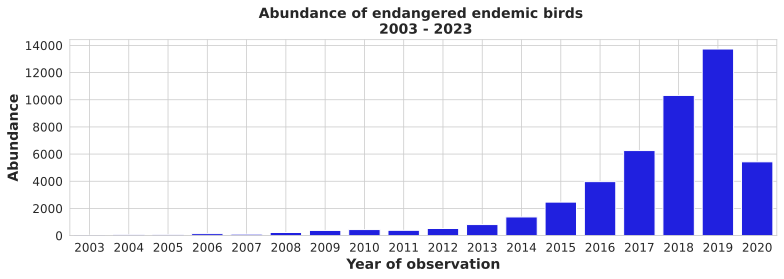

In [18]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
from matplotlib import font_manager

# Suprimir todas las advertencias
warnings.filterwarnings("ignore")

# Verificar si la fuente Calibri está disponible
if 'Calibri' not in [f.name for f in font_manager.fontManager.ttflist]:
    font_name = 'DejaVu Sans'  # Usa DejaVu Sans si Calibri no está disponible
else:
    font_name = 'Calibri'

# Filtrar los datos para incluir solo los avistamientos donde observation_count es mayor a 0
filtered_data = df_vu[df_vu['observation_count'] > 0]

# Convertir 'observation_date' a tipo datetime
filtered_data['observation_date'] = pd.to_datetime(filtered_data['observation_date'])

# Agrupar por año de observación y sumar el conteo de observaciones
df_annual = filtered_data.groupby(filtered_data['observation_date'].dt.year).agg({'observation_count': 'sum'}).reset_index()
df_annual = df_annual.rename(columns={'observation_date': 'year'})

# Crear el gráfico de barras
plt.figure(figsize=(11, 4))  # Ajustar el tamaño para carta

# Crear el gráfico de barras
sns.barplot(data=df_annual, x='year', y='observation_count', color='blue')

# Ajustar etiquetas y título
plt.xlabel('Year of observation', fontsize=14, weight='bold', fontname=font_name)  # Aumentar tamaño de la etiqueta del eje X
plt.ylabel('Abundance', fontsize=14, weight='bold', fontname=font_name)  # Aumentar tamaño de la etiqueta del eje Y
plt.title('Abundance of endangered endemic birds \n 2003 - 2023', weight='bold', fontsize=14, fontname=font_name)
plt.grid(True)

# Aumentar el tamaño de las marcas de los ejes y usar Calibri
plt.tick_params(axis='both', which='major', labelsize=12)
plt.xticks(rotation=0, ha='center', fontsize=12, fontname=font_name)
plt.yticks(fontsize=12, fontname=font_name)

# Ajustar el espaciado para evitar superposición
plt.tight_layout()

# Guardar la imagen
plt.savefig('Abundance_of_critically_endangered_bird_Henicorhina_negreti_by_effort_distance_and_department.png', bbox_inches='tight', dpi=300)
plt.savefig('Abundance_of_critically_endangered_bird_Henicorhina_negreti_by_effort_distance_and_department.pdf', bbox_inches='tight', dpi=300)

# Mostrar el gráfico
plt.show()








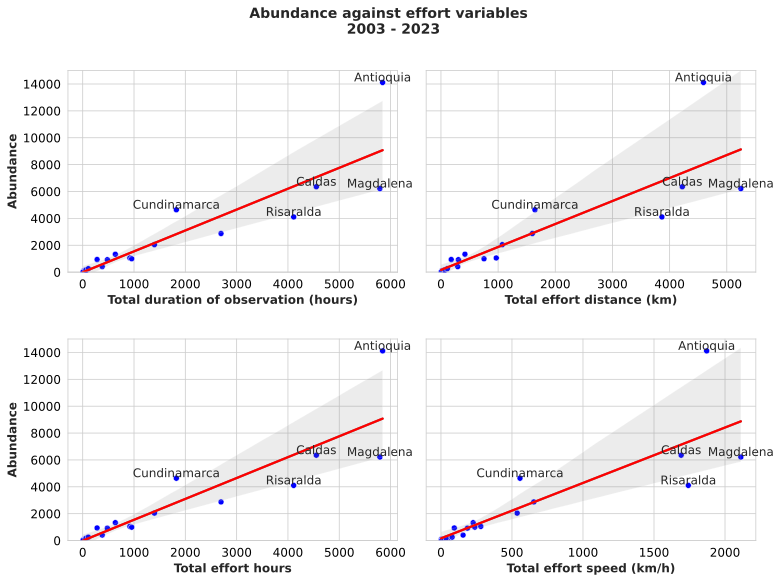

In [19]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings

# Suprimir todas las advertencias
warnings.filterwarnings("ignore")

# Filtrar los datos para incluir solo los avistamientos donde observation_count es mayor a 0
filtered_data = df_vu[df_vu['observation_count'] > 0]

# Convertir la duración de minutos a horas
filtered_data['duration_hours'] = filtered_data['duration_minutes'] / 60

# Crear una figura con subplots
fig, axes = plt.subplots(2, 2, figsize=(11, 8.5))  # Tamaño carta en pulgadas

# Lista de pares (x, xlabel)
effort_metrics = [
    ('duration_hours', 'Total duration of observation (hours)'),
    ('effort_distance_km', 'Total effort distance (km)'),
    ('effort_hours', 'Total effort hours'),
    ('effort_speed_kmph', 'Total effort speed (km/h)')
]

# Generar los gráficos de dispersión
for idx, (metric, xlabel) in enumerate(effort_metrics):
    # Agrupar por departamento y calcular la suma del esfuerzo y observaciones
    df_dept_summary = filtered_data.groupby('state').agg({metric: 'sum', 'observation_count': 'sum'}).reset_index()

    # Ordenar por número de observaciones y seleccionar los cinco primeros departamentos
    top5_dept = df_dept_summary.nlargest(5, 'observation_count')

    # Crear el gráfico de dispersión
    ax = axes[idx // 2, idx % 2]
    scatter_plot = sns.scatterplot(data=df_dept_summary, x=metric, y='observation_count', color='blue', ax=ax)

    # Añadir una línea de regresión gris con región de incertidumbre
    sns.regplot(data=df_dept_summary, x=metric, y='observation_count', scatter=False, ax=scatter_plot, line_kws={'color': 'grey'}, ci=95)

    # Añadir una línea de regresión roja sin región de incertidumbre
    sns.regplot(data=df_dept_summary, x=metric, y='observation_count', scatter=False, ax=scatter_plot, line_kws={'color': 'red'}, ci=None)

    # Añadir etiquetas de los cinco departamentos con mayor número de observaciones
    for i in range(top5_dept.shape[0]):
        x = top5_dept[metric].iloc[i]
        y = top5_dept['observation_count'].iloc[i]
        state = top5_dept['state'].iloc[i]

        # Condición específica para el departamento de Tolima con desplazamiento horizontal hacia la derecha
        if state == 'Tolima':
            ax.text(x + 50, y, state, fontsize=12, ha='left', fontname='DejaVu Sans')
        else:
            if x > df_dept_summary[metric].median():
                ax.text(x, y + 80, state, fontsize=12, ha='center', fontname='DejaVu Sans')
            else:
                ax.text(x, y - 80, state, fontsize=12, ha='center', fontname='DejaVu Sans')

    # Ajustar etiquetas y título del subplot
    ax.set_xlabel(xlabel, fontsize=12, weight='bold', fontname='DejaVu Sans')
    ax.set_ylabel('Abundance', fontsize=12, weight='bold', fontname='DejaVu Sans')
    ax.grid(True)
    ax.tick_params(axis='both', which='major', labelsize=12, labelcolor='black')

    # Eliminar el eje Y y sus números de las gráficas de la derecha
    if idx % 2 != 0:
        ax.set_ylabel('')
        ax.set_yticklabels([])

    # Ajustar el límite del eje Y
    ax.set_ylim(0, 15000)

# Ajustar el título general
plt.suptitle('Abundance against effort variables \n 2003 - 2023', weight='bold', fontsize=14, fontname='DejaVu Sans', y=0.95)

# Ajustar el espaciado para evitar superposición y agregar espacio entre las filas de gráficos
plt.tight_layout(rect=[0, 0, 1, 0.93], h_pad=3)

# Guardar la imagen
plt.savefig('Abundance_by_department_combined.png', dpi=300, bbox_inches='tight')
plt.savefig('Abundance_by_department_combined.pdf', dpi=300, bbox_inches='tight')

# Mostrar el gráfico
plt.show()




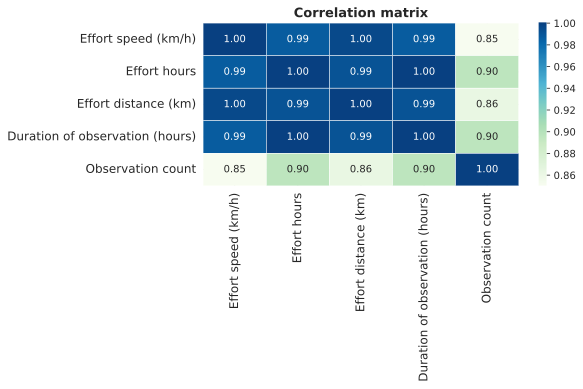

In [20]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
from matplotlib import font_manager

# Suprimir todas las advertencias
warnings.filterwarnings("ignore")

# Verificar si la fuente Calibri está disponible
if 'Calibri' not in [f.name for f in font_manager.fontManager.ttflist]:
    font_name = 'DejaVu Sans'  # Usa DejaVu Sans si Calibri no está disponible
else:
    font_name = 'Calibri'

# Filtrar los datos para incluir solo los avistamientos donde observation_count es mayor a 0
filtered_data = df_vu[df_vu['observation_count'] > 0]

# Convertir la duración de minutos a horas
filtered_data['duration_hours'] = filtered_data['duration_minutes'] / 60

# Agrupar por departamento y calcular la suma de las variables de interés
df_dept_summary = filtered_data.groupby('state').agg({
    'effort_speed_kmph': 'sum',
    'effort_hours': 'sum',
    'effort_distance_km': 'sum',
    'duration_hours': 'sum',
    'observation_count': 'sum'
}).reset_index()

# Seleccionar solo las columnas numéricas para la matriz de correlación
numeric_columns = df_dept_summary.select_dtypes(include='number')

# Calcular la matriz de correlación
correlation_matrix = numeric_columns.corr()

# Renombrar las columnas y filas para que coincidan con los nombres en la imagen
correlation_matrix.rename(index={
    'effort_speed_kmph': 'Effort speed (km/h)',
    'effort_hours': 'Effort hours',
    'effort_distance_km': 'Effort distance (km)',
    'duration_hours': 'Duration of observation (hours)',
    'observation_count': 'Observation count'
}, columns={
    'effort_speed_kmph': 'Effort speed (km/h)',
    'effort_hours': 'Effort hours',
    'effort_distance_km': 'Effort distance (km)',
    'duration_hours': 'Duration of observation (hours)',
    'observation_count': 'Observation count'
}, inplace=True)

# Crear un mapa de calor para la matriz de correlación
plt.figure(figsize=(8.5, 5.5))  # Ajustar el tamaño para que ocupe la mitad de una hoja carta

heatmap = sns.heatmap(correlation_matrix, annot=True, cmap='GnBu', linewidths=0.5, fmt=".2f")

# Ajustar las etiquetas de los ejes
heatmap.set_xticklabels(heatmap.get_xticklabels(), rotation=90, fontsize=12, fontname=font_name)
heatmap.set_yticklabels(heatmap.get_yticklabels(), rotation=0, fontsize=12, fontname=font_name)

plt.title('Correlation matrix', fontsize=13, weight='bold', fontname=font_name)

# Ajustar el espaciado para evitar superposición
plt.tight_layout()

# Guardar la imagen
plt.savefig('Correlation_matrix.png', dpi=300, bbox_inches='tight')
plt.savefig('Correlation_matrix.pdf', dpi=300, bbox_inches='tight')

plt.show()





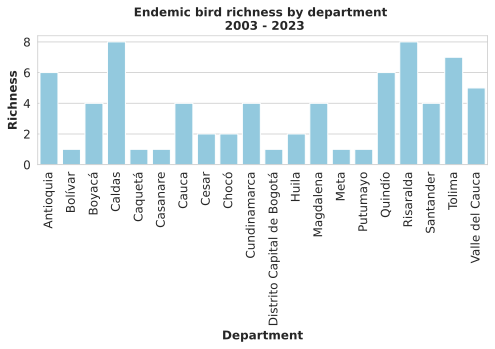

In [21]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
from matplotlib import font_manager

# Suprimir todas las advertencias
warnings.filterwarnings("ignore")

# Verificar si la fuente Calibri está disponible
if 'Calibri' not in [f.name for f in font_manager.fontManager.ttflist]:
    font_name = 'DejaVu Sans'  # Usa DejaVu Sans si Calibri no está disponible
else:
    font_name = 'Calibri'

# Filtrar los datos para incluir solo los avistamientos donde observation_count es mayor a 0
filtered_data = df_vu[df_vu['observation_count'] > 0]

# Agrupar por departamento y contar el número de especies distintas
df_species_count = filtered_data.groupby('state')['scientific_name'].nunique().reset_index()
df_species_count = df_species_count.rename(columns={'scientific_name': 'unique_species_count'})

# Crear el gráfico de barras
plt.figure(figsize=(7, 5))  # Reducir el tamaño de la figura para equilibrar los ejes
sns.barplot(data=df_species_count, x='state', y='unique_species_count', color='skyblue')

# Ajustar etiquetas y título
plt.xlabel('Department', fontsize=12, weight='bold', fontname=font_name)
plt.ylabel('Richness', fontsize=12, weight='bold', fontname=font_name)
plt.title('Endemic bird richness by department \n 2003 - 2023', weight='bold', fontsize=12, fontname=font_name)
plt.xticks(rotation=90, fontsize=12, fontname=font_name)
plt.yticks(fontsize=12, fontname=font_name)

# Aumentar el tamaño de las marcas de los ejes
plt.tick_params(axis='both', which='major', labelsize=12)

# Ajustar el espaciado para evitar superposición
plt.tight_layout()

# Guardar la imagen
plt.savefig('Endemic_bird_richness_by_department_2003_2023.png', bbox_inches='tight', dpi=300)
plt.savefig('Endemic_bird_richness_by_department_2003_2023.pdf', bbox_inches='tight', dpi=300)

# Mostrar el gráfico
plt.show()



ValueError: Unknown format code 'd' for object of type 'float'

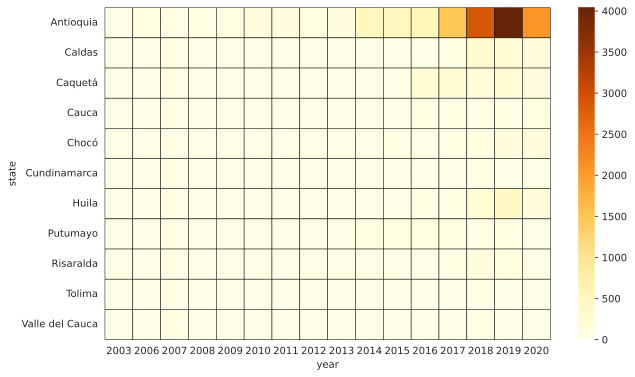

In [22]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
from matplotlib import font_manager
from matplotlib.colors import LinearSegmentedColormap

# Suprimir todas las advertencias
warnings.filterwarnings("ignore")

# Verificar si la fuente Calibri está disponible
if 'Calibri' not in [f.name for f in font_manager.fontManager.ttflist]:
    font_name = 'DejaVu Sans'  # Usa DejaVu Sans si Calibri no está disponible
else:
    font_name = 'Calibri'

# Filtrar los datos para incluir solo los avistamientos donde observation_count es mayor a 0 y para Hypopyrrhus pyrohypogaster
filtered_data = df_vu[(df_vu['observation_count'] > 0) & (df_vu['scientific_name'] == 'Hypopyrrhus pyrohypogaster')]

# Convertir 'observation_date' a tipo datetime
filtered_data['observation_date'] = pd.to_datetime(filtered_data['observation_date'])

# Agrupar por año y departamento, y sumar el conteo de observaciones
df_grouped = filtered_data.groupby([filtered_data['observation_date'].dt.year, 'state']).agg({'observation_count': 'sum'}).reset_index()
df_grouped = df_grouped.rename(columns={'observation_date': 'year'})

# Crear una tabla de contingencia para combinar la presencia de cada "state" por cada "year"
heatmap_data = pd.pivot_table(df_grouped, values='observation_count', index='state', columns='year', fill_value=0)

# Definir una paleta de colores personalizada con tres colores
colors = ["#1a9850", "#fee08b", "#d73027"]  # verde, amarillo, rojo
n_bins = 100  # Usar más segmentos para una transición más suave
cmap_name = 'custom_3color'
cm = LinearSegmentedColormap.from_list(cmap_name, colors, N=n_bins)

# Configurar el tamaño del gráfico
plt.figure(figsize=(10, 6))  # Reducir el tamaño para que ocupe menos espacio

# Crear el mapa de calor con la paleta de colores personalizada
heatmap = sns.heatmap(heatmap_data, cmap='YlOrBr', linewidths=.5, linecolor='black', annot=True, fmt='d')

# Configurar las etiquetas del eje x para múltiples líneas y centrarlas en cada celda
plt.xticks(rotation=90, fontsize=12, fontname=font_name)
plt.yticks(fontsize=12, fontname=font_name)
plt.xlabel('Year of observation', fontsize=14, weight='bold', fontname=font_name)
plt.ylabel('Department', fontsize=14, weight='bold', fontname=font_name)
plt.title('Abundance of endangered bird Hypopyrrhus pyrohypogaster by year and department \n 2003 - 2023', weight='bold', fontsize=14, fontname=font_name)

# Ajustar el tamaño de las marcas del eje y
plt.tick_params(axis='y', which='major', labelsize=12)

# Ajustar el espaciado para evitar superposición
plt.tight_layout()

# Guardar la imagen
plt.savefig('Abundance_of_endangered_bird_Hypopyrrhus_pyrohypogaster_by_year_and_department.png', bbox_inches='tight', dpi=300)
plt.savefig('Abundance_of_endangered_bird_Hypopyrrhus_pyrohypogaster_by_year_and_department.pdf', bbox_inches='tight', dpi=300)

# Mostrar el gráfico
plt.show()


In [23]:
# Aplicar el filtro
filtered_df_final = df_vu[(df_vu['scientific_name'] == 'Hypopyrrhus pyrohypogaster')]

# Mostrar el DataFrame filtrado
filtered_df_final

,checklist_id,last_edited_date,country,country_code,state,state_code,locality,locality_id,locality_type,latitude,...,trip_comments,scientific_name,observation_count,species_observed,status_co,effort_hours,effort_speed_kmph,hours_of_day,year,day_of_year
10,S60360053,2023-11-25 21:52:57.837266,Colombia,CO,Antioquia,CO-ANT,"Urbanización Atalaya de San Jorge, Envigado, A...",L6664911,P,6.161704,...,NaN,Hypopyrrhus pyrohypogaster,0,False,Vulnerable,0.533333,0.750000,7.983333,2019.0,278.0
25,S61357410,2023-11-25 21:52:57.837266,Colombia,CO,Antioquia,CO-ANT,"Urbanización Atalaya de San Jorge, Envigado, A...",L6664911,P,6.161704,...,NaN,Hypopyrrhus pyrohypogaster,0,False,Vulnerable,0.650000,0.830769,7.483333,2019.0,315.0
40,S51579402,2023-11-25 21:52:57.837266,Colombia,CO,Antioquia,CO-ANT,"Urbanización Atalaya de San Jorge, Envigado, A...",L6664911,P,6.161704,...,NaN,Hypopyrrhus pyrohypogaster,0,False,Vulnerable,0.400000,0.000000,7.083333,2019.0,12.0
55,S59971734,2023-11-25 21:52:57.837266,Colombia,CO,Antioquia,CO-ANT,"Urbanización Atalaya de San Jorge, Envigado, A...",L6664911,P,6.161704,...,NaN,Hypopyrrhus pyrohypogaster,0,False,Vulnerable,0.750000,0.666667,7.700000,2019.0,264.0
70,S52070627,2023-11-25 21:52:57.837266,Colombia,CO,Antioquia,CO-ANT,"Urbanización Atalaya de San Jorge, Envigado, A...",L6664911,P,6.161704,...,NaN,Hypopyrrhus pyrohypogaster,0,False,Vulnerable,0.483333,0.641379,17.016667,2019.0,26.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6065590,G7635775,2022-10-25 02:01:53.77827,Colombia,CO,Boyacá,CO-BOY,"Bosque, Sendero salto Candelas, vda. Corinto, ...",L13525414,P,5.422280,...,NaN,Hypopyrrhus pyrohypogaster,0,False,Vulnerable,0.883333,1.494340,9.033333,2022.0,2.0
6065605,G7636828,2022-02-17 18:09:32.218588,Colombia,CO,La Guajira,CO-LAG,SFF Los Flamencos - Ciénaga del Navío Quebrado,L843776,H,11.418022,...,Boat trip from Boca down to about 5km south on...,Hypopyrrhus pyrohypogaster,0,False,Vulnerable,2.533333,2.368421,15.166667,2022.0,2.0
6065620,G7637309,2022-10-26 05:29:12.817965,Colombia,CO,Risaralda,CO-RIS,Alto de La Linea,L3010133,H,5.169848,...,NaN,Hypopyrrhus pyrohypogaster,0,False,Vulnerable,2.466667,0.454054,14.650000,2022.0,2.0
6065635,G7637526,2022-01-02 18:52:37.153398,Colombia,CO,Meta,CO-MET,Villa Paulina,L15473218,P,4.152331,...,NaN,Hypopyrrhus pyrohypogaster,0,False,Vulnerable,0.166667,0.000000,18.350000,2022.0,2.0


In [24]:
# Aplicar el filtro
filtered_df_final2_VU = filtered_df_final[(filtered_df_final['state'] == 'Antioquia')]

# Mostrar el DataFrame filtrado
filtered_df_final2_VU

,checklist_id,last_edited_date,country,country_code,state,state_code,locality,locality_id,locality_type,latitude,...,trip_comments,scientific_name,observation_count,species_observed,status_co,effort_hours,effort_speed_kmph,hours_of_day,year,day_of_year
10,S60360053,2023-11-25 21:52:57.837266,Colombia,CO,Antioquia,CO-ANT,"Urbanización Atalaya de San Jorge, Envigado, A...",L6664911,P,6.161704,...,NaN,Hypopyrrhus pyrohypogaster,0,False,Vulnerable,0.533333,0.750000,7.983333,2019.0,278.0
25,S61357410,2023-11-25 21:52:57.837266,Colombia,CO,Antioquia,CO-ANT,"Urbanización Atalaya de San Jorge, Envigado, A...",L6664911,P,6.161704,...,NaN,Hypopyrrhus pyrohypogaster,0,False,Vulnerable,0.650000,0.830769,7.483333,2019.0,315.0
40,S51579402,2023-11-25 21:52:57.837266,Colombia,CO,Antioquia,CO-ANT,"Urbanización Atalaya de San Jorge, Envigado, A...",L6664911,P,6.161704,...,NaN,Hypopyrrhus pyrohypogaster,0,False,Vulnerable,0.400000,0.000000,7.083333,2019.0,12.0
55,S59971734,2023-11-25 21:52:57.837266,Colombia,CO,Antioquia,CO-ANT,"Urbanización Atalaya de San Jorge, Envigado, A...",L6664911,P,6.161704,...,NaN,Hypopyrrhus pyrohypogaster,0,False,Vulnerable,0.750000,0.666667,7.700000,2019.0,264.0
70,S52070627,2023-11-25 21:52:57.837266,Colombia,CO,Antioquia,CO-ANT,"Urbanización Atalaya de San Jorge, Envigado, A...",L6664911,P,6.161704,...,NaN,Hypopyrrhus pyrohypogaster,0,False,Vulnerable,0.483333,0.641379,17.016667,2019.0,26.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6064525,G7638691,2022-01-27 12:01:04.274946,Colombia,CO,Antioquia,CO-ANT,Límites Barbosa-Don Matías,L17261225,P,6.506407,...,NaN,Hypopyrrhus pyrohypogaster,0,False,Vulnerable,0.700000,0.842857,10.566667,2021.0,364.0
6064540,G7638693,2022-01-05 13:11:01.131133,Colombia,CO,Antioquia,CO-ANT,Autopista al río Magdalena Popalito,L17261280,P,6.491236,...,NaN,Hypopyrrhus pyrohypogaster,0,False,Vulnerable,0.366667,1.772727,11.733333,2021.0,364.0
6064555,G7614303,2023-10-24 04:02:13.955611,Colombia,CO,Antioquia,CO-ANT,Jardin Cock-of-the-Rock Lek,L2719023,H,5.596620,...,NaN,Hypopyrrhus pyrohypogaster,0,False,Vulnerable,0.933333,0.546429,16.950000,2021.0,201.0
6064810,G7617030,2021-12-31 19:27:42.369418,Colombia,CO,Antioquia,CO-ANT,O2 Reserve,L17269191,P,6.583066,...,NaN,Hypopyrrhus pyrohypogaster,0,False,Vulnerable,6.000000,1.333333,14.083333,2021.0,362.0


In [25]:
# Guardar el DataFrame filtrado en un archivo CSV en la ruta deseada
filtered_df_final2_VU.to_csv('/content/drive/MyDrive/Proyecto aplicado /Procesamiento objetivo 1/filtered_df_final2_VU.csv', index=False)

# Descargar el archivo en Google Colab
from google.colab import files
files.download('/content/drive/MyDrive/Proyecto aplicado /Procesamiento objetivo 1/filtered_df_final2_VU.csv')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>